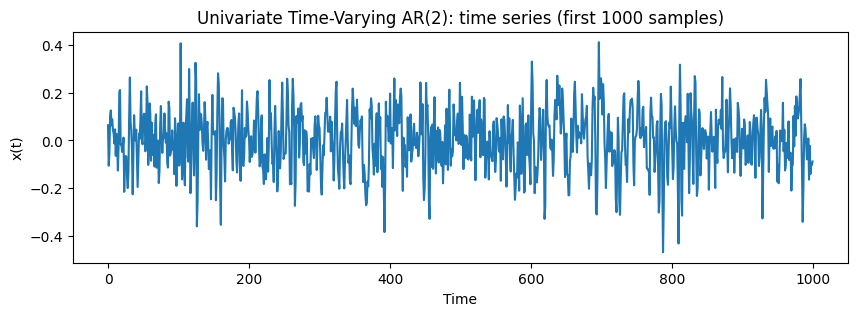

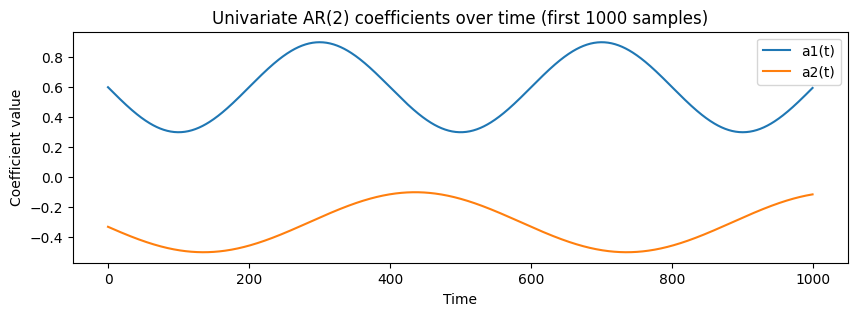

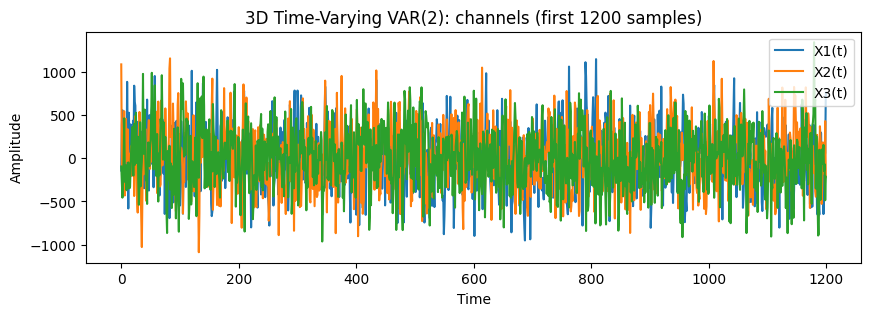

Simulation complete: stable univariate TV-AR(2) and 3D TV-VAR(2) generated.


In [2]:
# Fix multivariate simulation: use true 3D rotation matrices (orthogonal) to keep stability.
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(11)

def Rz(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s, 0.0],
                     [s,  c, 0.0],
                     [0.0, 0.0, 1.0]])

def Ry(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[ c, 0.0,  s],
                     [0.0, 1.0, 0.0],
                     [-s, 0.0,  c]])

def simulate_tvvar3_stable(T=4000, burn_in=300, noise_cov=None):
    """
    3D time-varying VAR(2) with smoothly rotating coupling matrices.
    Ensures stability by keeping eigenvalues small (spectral radius < 1).
    """
    if noise_cov is None:
        noise_cov =100000 * np.eye(3)
    L = np.linalg.cholesky(noise_cov)

    # stable diagonal eigenvalues for A1, A2
    alpha = np.array([0.45, 0.35, 0.30])  # first-lag magnitudes
    beta  = np.array([-0.10, -0.08, -0.06])  # second-lag magnitudes (negative helps damping)

    def angles(k):
        th1 = 2*np.pi * k / 500.0
        th2 = 2*np.pi * k / 900.0 + 0.7
        return th1, th2

    T_total = T + burn_in
    X = np.zeros((T_total, 3))
    eps = rng.normal(size=(T_total, 3)) @ L.T

    for k in range(2, T_total):
        th1, th2 = angles(k)
        R1 = Rz(th1) @ Ry(th1 * 0.5)
        R2 = Ry(th2) @ Rz(th2 * 0.5)

        A1 = R1 @ np.diag(alpha) @ R1.T  # orthogonally similar -> eigenvals are alpha
        A2 = R2 @ np.diag(beta)  @ R2.T  # eigenvals are beta

        X[k] = A1 @ X[k-1] + A2 @ X[k-2] + eps[k]

    return X[burn_in:], alpha, beta

# Re-run univariate from previous cell to keep together for the user
def simulate_tvar_univariate(T=3000, 
                             a1_base=0.6, a1_amp=0.3, a1_period=400, a1_phase=0.0,
                             a2_base=-0.3, a2_amp=0.2, a2_period=600, a2_phase=1.2,
                             noise_std=0.1, burn_in=200):
    T_total = T + burn_in
    t = np.arange(T_total)

    a1 = a1_base + a1_amp * np.sin(2*np.pi * t / a1_period + a1_phase)
    a2 = a2_base + a2_amp * np.sin(2*np.pi * t / a2_period + a2_phase)

    x = np.zeros(T_total)
    eps = rng.normal(0.0, noise_std, size=T_total)

    for k in range(2, T_total):
        x[k] = a1[k] * x[k-1] + a2[k] * x[k-2] + eps[k]

    return x[burn_in:], a1[burn_in:], a2[burn_in:]

# Run stable simulations
x_uni, a1_tv, a2_tv = simulate_tvar_univariate(T=4000)
X3, alpha_base, beta_base = simulate_tvvar3_stable(T=4000)

# Plot: Univariate TV-AR(2) (first 1000 samples)
plt.figure(figsize=(10, 3))
plt.plot(x_uni[:1000])
plt.title("Univariate Time-Varying AR(2): time series (first 1000 samples)")
plt.xlabel("Time")
plt.ylabel("x(t)")
plt.show()

# Plot: Coefficients over time (first 1000 samples)
plt.figure(figsize=(10, 3))
plt.plot(a1_tv[:1000], label="a1(t)")
plt.plot(a2_tv[:1000], label="a2(t)")
plt.title("Univariate AR(2) coefficients over time (first 1000 samples)")
plt.xlabel("Time")
plt.ylabel("Coefficient value")
plt.legend()
plt.show()

# Plot: 3D TV-VAR(2) channels (first 1200 samples)
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.plot(X3[:1200, i], label=f"X{i+1}(t)")
plt.title("3D Time-Varying VAR(2): channels (first 1200 samples)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

print("Simulation complete: stable univariate TV-AR(2) and 3D TV-VAR(2) generated.")


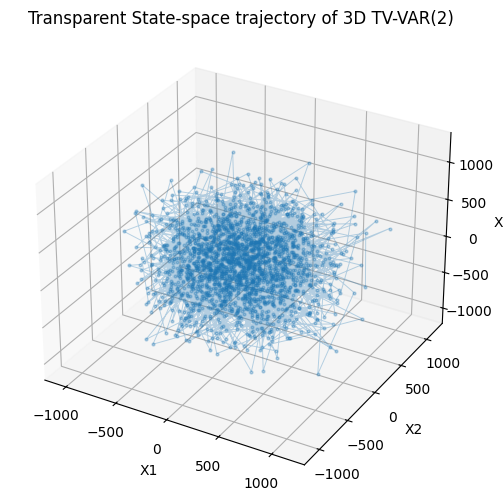

In [3]:
# Plot with both markers and connecting line partially transparent (alpha < 1.0).

window = slice(0, 2500)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot as line with small transparent markers
ax.plot(
    X3[window,0], X3[window,1], X3[window,2],
    marker='o', markersize=2, linewidth=0.7,
    alpha=0.3  # apply transparency to both line and markers
)

ax.set_title("Transparent State-space trajectory of 3D TV-VAR(2)")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
plt.show()


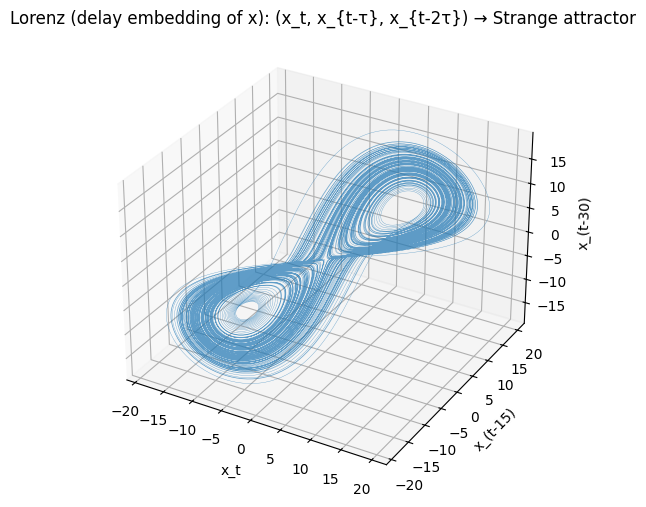

In [4]:
# Fix the slice arithmetic for the Lorenz delay embedding.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def lorenz(T_steps=40000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*0.005*k1[0], y + 0.5*0.005*k1[1], z + 0.5*0.005*k1[2])
        k3 = f(x + 0.5*0.005*k2[0], y + 0.5*0.005*k2[1], z + 0.5*0.005*k2[2])
        k4 = f(x + 0.005*k3[0], y + 0.005*k3[1], z + 0.005*k3[2])
        x += (0.005/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (0.005/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (0.005/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

xs, ys, zs = lorenz()

tau = 15
start = 2 * tau
X1 = xs[start:]
X2 = xs[start - tau:-tau]
X3 = xs[start - 2*tau:-2*tau]

fig2 = plt.figure(figsize=(7,6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(X1, X2, X3, linewidth=0.25, alpha=0.7)
ax2.set_title("Lorenz (delay embedding of x): (x_t, x_{t-τ}, x_{t-2τ}) → Strange attractor")
ax2.set_xlabel("x_t")
ax2.set_ylabel(f"x_(t-{tau})")
ax2.set_zlabel(f"x_(t-{2*tau})")
plt.show()


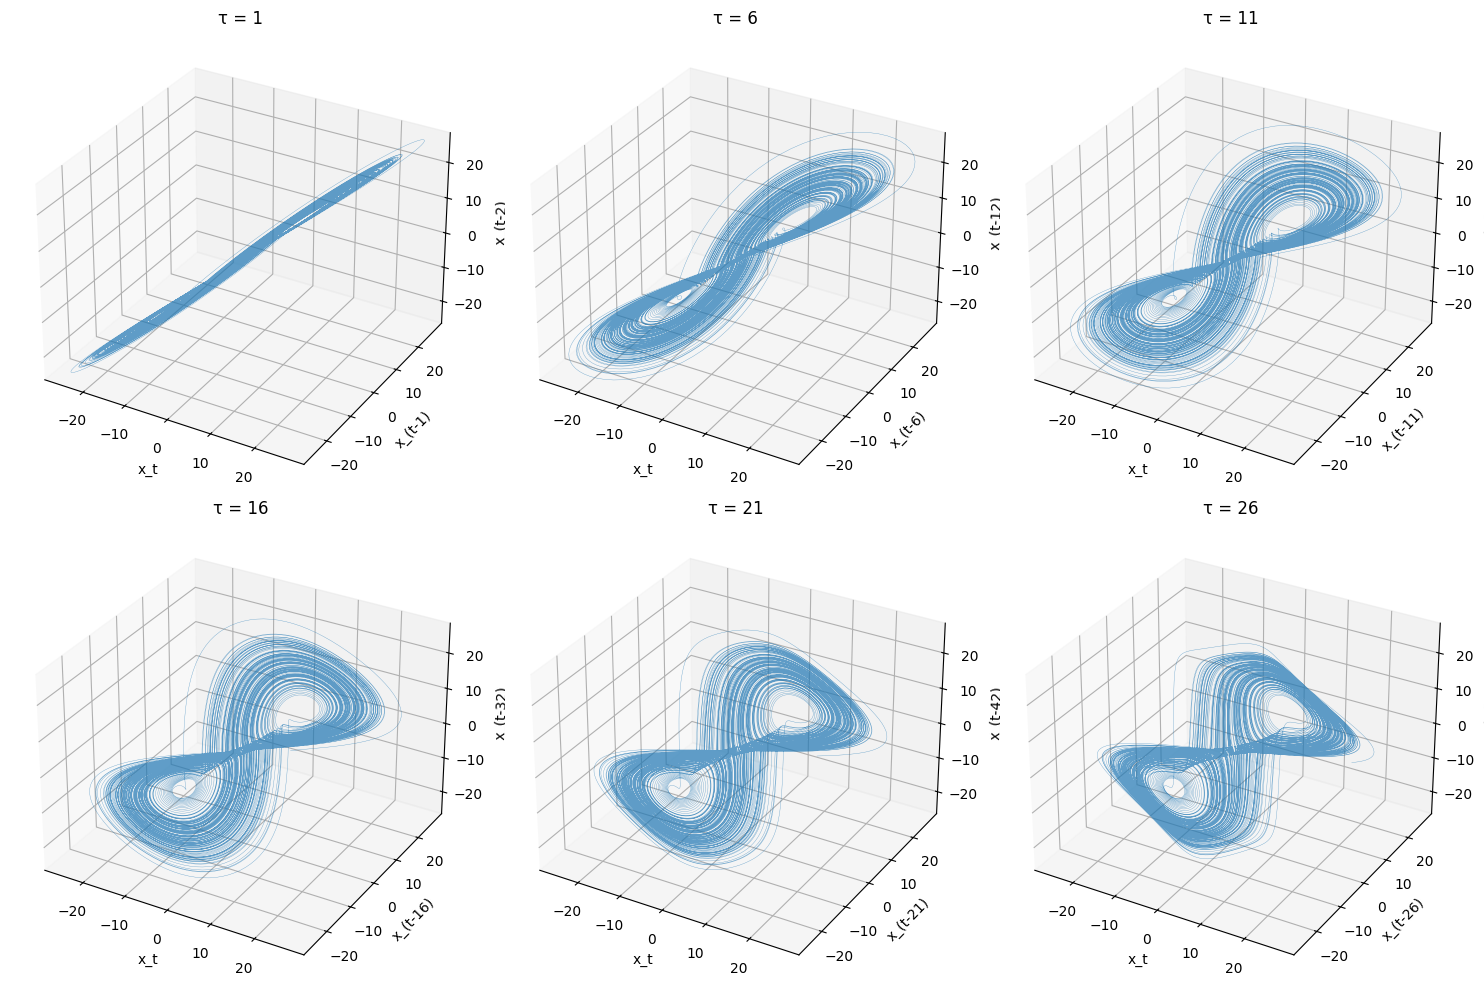

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def lorenz(T_steps=40000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
        k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
        k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

# Generate Lorenz data
xs, ys, zs = lorenz()

# Tau values from 1 to 30 in steps of 5
taus = list(range(1, 31, 5))

fig = plt.figure(figsize=(15, 10))

for i, tau in enumerate(taus, 1):
    start = 2 * tau
    X1 = ys[start:]
    X2 = ys[start - tau:-tau]
    X3 = ys[start - 2*tau:-2*tau]
    
    ax = fig.add_subplot(2, 3, i, projection='3d')
    ax.plot(X1, X2, X3, linewidth=0.25, alpha=0.7)
    ax.set_title(f"τ = {tau}")
    ax.set_xlabel("x_t")
    ax.set_ylabel(f"x_(t-{tau})")
    ax.set_zlabel(f"x_(t-{2*tau})")

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# --- Lorenz simulator (as before) ---
def lorenz(T_steps=40000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        dx = sigma*(y-x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        x += dx*dt; y += dy*dt; z += dz*dt
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs), dt

# --- simulate Lorenz ---
xs, ys, zs, dt = lorenz()
fs = 1.0 / dt  # sampling rate

# --- use MNE to compute PSD (Welch) ---
psds, freqs = mne.time_frequency.psd_array_welch(xs[np.newaxis, :],
                                                 sfreq=fs,
                                                 fmin=0.1, fmax=50,
                                                 n_fft=2048,
                                                 n_overlap=1024,
                                                 average='mean')

# psds has shape (n_channels, n_freqs); here just 1 channel
plt.figure(figsize=(6,4))
plt.semilogy(freqs, psds[0], color='k')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (a.u./Hz)")
plt.title("Lorenz x-component PSD (MNE)")
plt.grid(True, ls="--", alpha=0.3)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'mne'

In [ ]:
import sys; print(sys.executable)
import mne; print(mne.__version__)


/usr/local/bin/python3


ModuleNotFoundError: No module named 'mne'

ModuleNotFoundError: No module named 'mne'

In [ ]:
# least square vs p (elbow point)

In [ ]:
# -*- coding: utf-8 -*-
"""
Make two publication-style mosaics (PNG):
  1) Torus (from a quasiperiodic time series lag embedding)
  2) Lorenz (delay embedding of x(t))
Layout: big 3D panel on the left, 3 small 2D projections stacked on the right.

Dependencies: numpy, matplotlib, pillow
"""

import os
from pathlib import Path
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed by mpl)


# ---------- Utilities ----------

def fig_to_image(fig, dpi=250) -> Image.Image:
    """Render a Matplotlib figure to a PIL Image (in memory; no temp files)."""
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf).convert("RGB")


def compose_mosaic(main_img: Image.Image,
                   side_imgs: list[Image.Image],
                   out_path: Path,
                   big_size=(1600, 1200),
                   small_size=(650, 400),
                   bg=(255, 255, 255)) -> Path:
    """
    Compose a mosaic: big image on the left; 3 side images stacked right.
    Returns the path where the final PNG is saved.
    """
    big_w, big_h = big_size
    small_w, small_h = small_size
    canvas_w, canvas_h = big_w + small_w, big_h

    # Resize panels with high-quality resampling
    try:
        Resample = Image.Resampling.LANCZOS
    except AttributeError:
        Resample = Image.LANCZOS

    main_resized = main_img.resize((big_w, big_h), Resample)
    side_resized = [im.resize((small_w, small_h), Resample) for im in side_imgs]

    canvas = Image.new("RGB", (canvas_w, canvas_h), bg)
    canvas.paste(main_resized, (0, 0))
    for i, im in enumerate(side_resized[:3]):
        canvas.paste(im, (big_w, i * small_h))

    out_path.parent.mkdir(parents=True, exist_ok=True)
    canvas.save(out_path)
    return out_path


def proj_2d_panel(a, b, label_a, label_b, title, as_line=False) -> Image.Image:
    """Create a 2D projection panel and return as a PIL image."""
    fig = plt.figure(figsize=(3.4, 2.0))
    if as_line:
        plt.plot(a, b, linewidth=0.25, alpha=0.7)
    else:
        plt.plot(a, b, ".", alpha=0.25, markersize=1.2)
    plt.title(title)
    plt.xlabel(label_a)
    plt.ylabel(label_b)
    plt.axis("equal")
    return fig_to_image(fig)


# ---------- Torus (quasiperiodic) ----------

def build_torus_panels(T=8000, period1=120.0, amp2=0.7, tau1=12, tau2=24):
    """
    Generate a quasiperiodic signal x(t) with incommensurate periods,
    embed into 3D lag space (x_t, x_{t-tau1}, x_{t-tau2}),
    and return the main 3D panel + three 2D projection panels as PIL images.
    """
    phi = (1 + np.sqrt(5)) / 2  # golden ratio
    period2 = period1 * phi

    t = np.arange(T, dtype=float)
    x = np.sin(2*np.pi * t / period1) + amp2 * np.sin(2*np.pi * t / period2)

    start = max(tau1, tau2)
    X = x[start:]
    Y = x[start - tau1:-tau1]
    Z = x[start - tau2:-tau2]
    n = min(len(X), len(Y), len(Z))
    X, Y, Z = X[:n], Y[:n], Z[:n]

    # 3D main
    fig3d = plt.figure(figsize=(6, 6))
    ax3d = fig3d.add_subplot(111, projection="3d")
    ax3d.plot(X, Y, Z, ".", alpha=0.25, markersize=1.2)
    ax3d.set_title("Quasiperiodic lag embedding: (x_t, x_{t-τ1}, x_{t-τ2})")
    ax3d.set_xlabel("x_t")
    ax3d.set_ylabel(f"x_(t-{tau1})")
    ax3d.set_zlabel(f"x_(t-{tau2})")
    main_img = fig_to_image(fig3d)

    # 2D side panels
    p12 = proj_2d_panel(X, Y, "x_t", f"x_(t-{tau1})", "(x_t, x_{t-τ1})")
    p13 = proj_2d_panel(X, Z, "x_t", f"x_(t-{tau2})", "(x_t, x_{t-τ2})")
    p23 = proj_2d_panel(Y, Z, f"x_(t-{tau1})", f"x_(t-{tau2})", "(x_{t-τ1}, x_{t-τ2})")

    return main_img, [p12, p13, p23]


# ---------- Lorenz (delay embedding) ----------

def integrate_lorenz(T_steps=40000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3,
                     x0=(1.0, 1.0, 1.0)) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Integrate Lorenz with RK4; return arrays x(t), y(t), z(t)."""
    x, y, z = x0
    xs, ys, zs = [], [], []

    for _ in range(T_steps):
        def f(x, y, z):
            dx = sigma * (y - x)
            dy = x * (rho - z) - y
            dz = x * y - beta * z
            return dx, dy, dz

        k1 = f(x, y, z)
        k2 = f(x + 0.5 * dt * k1[0], y + 0.5 * dt * k1[1], z + 0.5 * dt * k1[2])
        k3 = f(x + 0.5 * dt * k2[0], y + 0.5 * dt * k2[1], z + 0.5 * dt * k2[2])
        k4 = f(x + dt * k3[0], y + dt * k3[1], z + dt * k3[2])

        x += (dt / 6.0) * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0])
        y += (dt / 6.0) * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1])
        z += (dt / 6.0) * (k1[2] + 2 * k2[2] + 2 * k3[2] + k4[2])

        xs.append(x); ys.append(y); zs.append(z)

    return np.array(xs), np.array(ys), np.array(zs)


def build_lorenz_panels(T_steps=40000, dt=0.005, tau=15):
    """
    Delay-embed Lorenz x(t) → (x_t, x_{t-τ}, x_{t-2τ})
    and return the main 3D panel + three 2D projection panels as PIL images.
    """
    xs, _, _ = integrate_lorenz(T_steps=T_steps, dt=dt)

    start = 2 * tau
    X1 = xs[start:]
    X2 = xs[start - tau:-tau]
    X3 = xs[start - 2 * tau:-2 * tau]

    # 3D main
    fig3d = plt.figure(figsize=(6, 6))
    ax3d = fig3d.add_subplot(111, projection="3d")
    ax3d.plot(X1, X2, X3, linewidth=0.4, alpha=0.7)
    ax3d.set_title("Lorenz delay-embedding: (x_t, x_{t-τ}, x_{t-2τ})")
    ax3d.set_xlabel("x_t")
    ax3d.set_ylabel(f"x_(t-{tau})")
    ax3d.set_zlabel(f"x_(t-{2 * tau})")
    main_img = fig_to_image(fig3d)

    # 2D side panels (lines = clearer structure)
    p12 = proj_2d_panel(X1, X2, "x_t", f"x_(t-{tau})", "(x_t, x_{t-τ})", as_line=True)
    p13 = proj_2d_panel(X1, X3, "x_t", f"x_(t-{2 * tau})", "(x_t, x_{t-2τ})", as_line=True)
    p23 = proj_2d_panel(X2, X3, f"x_(t-{tau})", f"x_(t-{2 * tau})", "(x_{t-τ}, x_{t-2τ})", as_line=True)

    return main_img, [p12, p13, p23]


# ---------- Main ----------

def main(out_dir: Path | str = "./figs"):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Torus mosaic
    torus_main, torus_sides = build_torus_panels(T=8000, period1=120.0, amp2=0.7, tau1=12, tau2=24)
    torus_path = compose_mosaic(torus_main, torus_sides, out_dir / "torus_panel.png")
    print("Saved:", torus_path.resolve())

    # Lorenz mosaic
    lorenz_main, lorenz_sides = build_lorenz_panels(T_steps=40000, dt=0.005, tau=15)
    lorenz_path = compose_mosaic(lorenz_main, lorenz_sides, out_dir / "lorenz_panel.png")
    print("Saved:", lorenz_path.resolve())


if __name__ == "__main__":
    main("./figs")  # change to any writeable directory you prefer


Saved: /Users/Erfan/Documents/GitHub/StocasticDiffEq_Simulation/figs/torus_panel.png
Saved: /Users/Erfan/Documents/GitHub/StocasticDiffEq_Simulation/figs/lorenz_panel.png


Fit AR

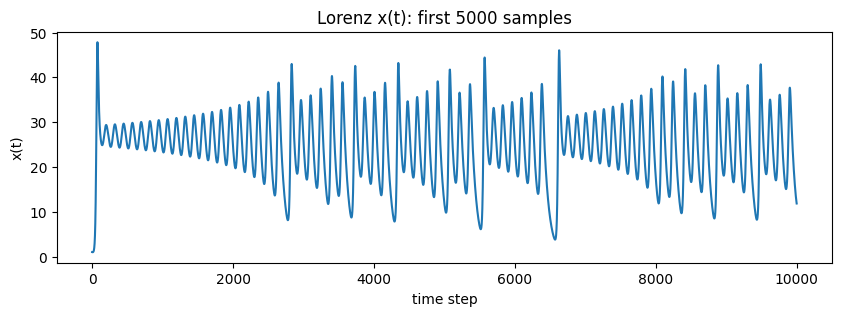

Selected AR order by BIC: 17
AIC (selected): -1536056.280413326
BIC (selected): -1535901.5486397564
Intercept + AR coeffs:
[-3.88610568e-11  8.07896112e+00 -2.67947268e+01  4.40094864e+01
 -2.89737957e+01 -1.27295426e+01  2.44553443e+01  7.56514720e+00
 -2.00940470e+01 -7.90132718e+00  1.74047657e+01  8.15898167e+00
 -1.71741843e+01 -4.69805098e+00  2.05467656e+01 -1.52340686e+01
  5.03906603e+00 -6.58775023e-01]


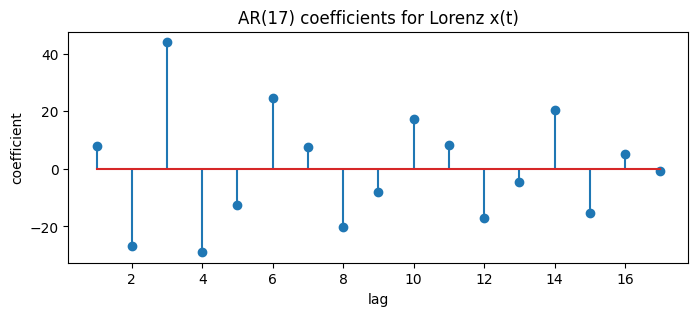

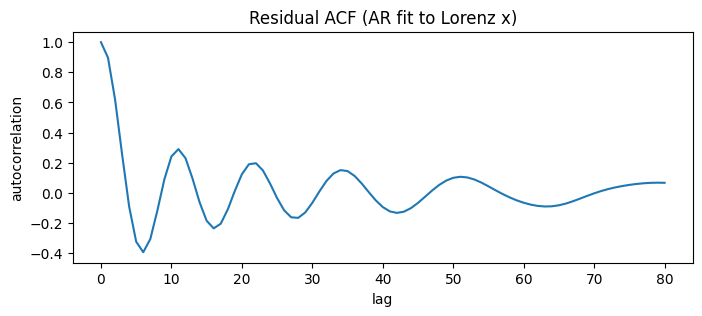

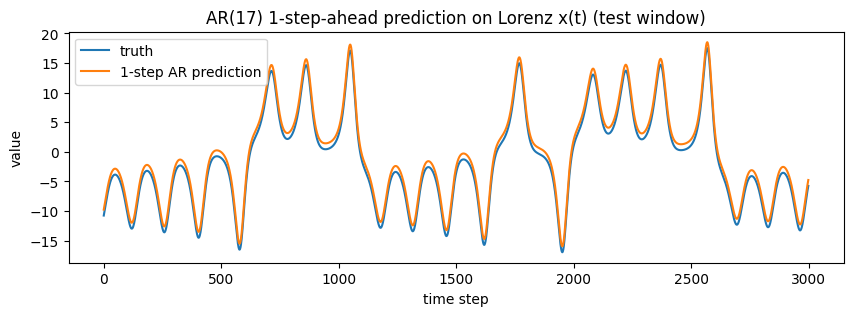

Done. This AR(p) is a linear approximation; higher p may fit better but risks overfitting.


In [ ]:
# Re-run (kernel reset): AR representation of Lorenz x(t)

import numpy as np
import matplotlib.pyplot as plt

def lorenz(T_steps=40000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
        k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
        k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

xs, ys, zs = lorenz()

plt.figure(figsize=(10, 3))
plt.plot(zs[:10000])
plt.title("Lorenz x(t): first 5000 samples")
plt.xlabel("time step")
plt.ylabel("x(t)")
plt.show()

def lag_matrix(x, p, include_intercept=True):
    N = len(x)
    n_eff = N - p
    y = x[p:].copy()
    X = np.zeros((n_eff, p + (1 if include_intercept else 0)))
    if include_intercept:
        X[:, 0] = 1.0
        for i in range(p):
            X[:, i+1] = x[p-1-i : N-1-i]
    else:
        for i in range(p):
            X[:, i] = x[p-1-i : N-1-i]
    return X, y

def fit_ar_ols(x, p, include_intercept=True):
    X, y = lag_matrix(x, p, include_intercept=include_intercept)
    coef, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    yhat = X @ coef
    resid = y - yhat
    n = len(y)
    k = len(coef)
    sigma2 = (resid @ resid) / n
    AIC = 2*k + n * np.log(sigma2)
    BIC = k * np.log(n) + n * np.log(sigma2)
    return coef, resid, sigma2, AIC, BIC, y, yhat

def choose_order(x, p_min=2, p_max=60):
    best = None
    for p in range(p_min, p_max+1):
        coef, resid, sigma2, AIC, BIC, y, yhat = fit_ar_ols(x, p, include_intercept=True)
        rec = dict(p=p, coef=coef, resid=resid, sigma2=sigma2, AIC=AIC, BIC=BIC, y=y, yhat=yhat)
        if (best is None) or (rec["BIC"] < best["BIC"]):
            best = rec
    return best

best = choose_order(xs, p_min=2, p_max=60)

print("Selected AR order by BIC:", best["p"])
print("AIC (selected):", best["AIC"])
print("BIC (selected):", best["BIC"])
print("Intercept + AR coeffs:")
print(best["coef"])

plt.figure(figsize=(8, 3))
coef = best["coef"]
# plt.stem(np.arange(1, best["p"]+1), coef[1:], use_line_collection=True)
plt.stem(np.arange(1, best["p"]+1), coef[1:])
plt.title(f"AR({best['p']}) coefficients for Lorenz x(t)")
plt.xlabel("lag")
plt.ylabel("coefficient")
plt.show()

def acf(sig, nlags=80):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac = ac / ac[0]
    return ac[:nlags+1]

plt.figure(figsize=(8, 3))
plt.plot(acf(best["resid"], nlags=80))
plt.title("Residual ACF (AR fit to Lorenz x)")
plt.xlabel("lag")
plt.ylabel("autocorrelation")
plt.show()

p = best["p"]
train_end = len(xs) - 3000
coef_tr, resid_tr, sigma2_tr, AIC_tr, BIC_tr, y_tr, yhat_tr = fit_ar_ols(xs[:train_end], p, include_intercept=True)

def predict_ar_1step(x_full, coef, p, start_idx):
    n = len(x_full)
    preds = np.zeros(n - start_idx)
    for t in range(start_idx, n):
        xlags = x_full[t-1 : t-p-1 : -1]
        pred = coef[0] + np.dot(coef[1:], xlags)
        preds[t - start_idx] = pred
    return preds

preds = predict_ar_1step(xs, coef_tr, p, start_idx=train_end)

plt.figure(figsize=(10, 3))
t_axis = np.arange(train_end, len(xs))
plt.plot(xs[t_axis], label="truth")
plt.plot(preds+1, label="1-step AR prediction")
plt.title(f"AR({p}) 1-step-ahead prediction on Lorenz x(t) (test window)")
plt.xlabel("time step")
plt.ylabel("value")
plt.legend()
plt.show()

print("Done. This AR(p) is a linear approximation; higher p may fit better but risks overfitting.")


non-linear AR fit

Linear AR(10) test:   MSE=0.000000, MAE=0.000001, corr=1.0000
Nonlinear NAR (deg 3) test: MSE=0.000005, MAE=0.001571, corr=1.0000
# polynomial features (excl. intercept): 285


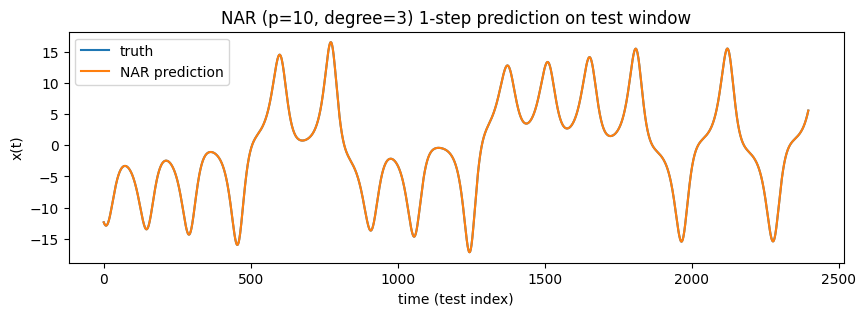

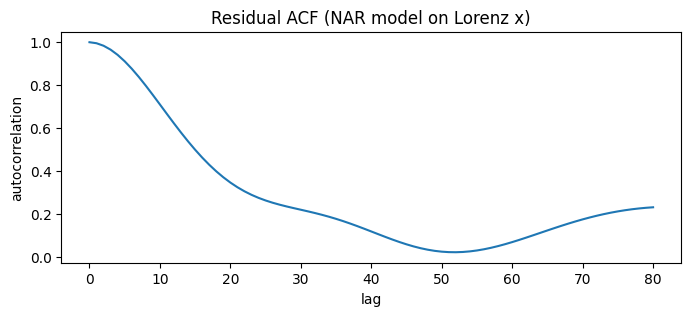

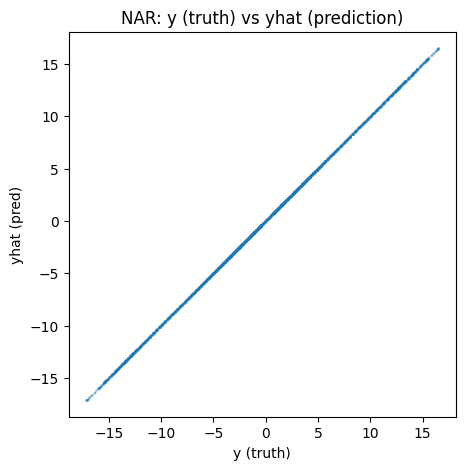

Done.


In [ ]:
# Faster NAR demo: smaller series, fewer lags, degree 3 (≈285 features).
# Should complete comfortably under the time limit.

import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

def lorenz(T_steps=12000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
        k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
        k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

def make_lag_matrix(x, p):
    N = len(x)
    n_eff = N - p
    y = x[p:].copy()
    X = np.zeros((n_eff, p))
    for i in range(p):
        X[:, i] = x[p-1-i : N-1-i]
    return X, y

def poly_expand(X, degree=3):
    n, p = X.shape
    cols = []
    for d in range(1, degree+1):
        for comb in combinations_with_replacement(range(p), d):
            cols.append(np.prod(X[:, comb], axis=1))
    Z = np.column_stack(cols) if cols else np.zeros((n, 0))
    return Z

def standardize_train_test(Z_tr, Z_te):
    mu = Z_tr.mean(axis=0)
    sd = Z_tr.std(axis=0)
    sd[sd == 0] = 1.0
    return (Z_tr - mu)/sd, (Z_te - mu)/sd

def fit_ridge(D, y, alpha=1e-2, intercept_included=True):
    DtD = D.T @ D
    P = np.eye(D.shape[1])
    if intercept_included:
        P[0,0] = 0.0
    A = DtD + alpha * P
    b = D.T @ y
    w = np.linalg.solve(A, b)
    return w

def predict_design(D, w):
    return D @ w

# Settings
p = 10
deg = 3
alpha = 1e-2

xs, ys, zs = lorenz()
Xlags, y = make_lag_matrix(xs, p)
N = len(y)
n_tr = int(0.8 * N)
X_tr, y_tr = Xlags[:n_tr], y[:n_tr]
X_te, y_te = Xlags[n_tr:], y[n_tr:]

# Baseline linear AR(p)
Dlin_tr = np.column_stack([np.ones(n_tr), X_tr])
Dlin_te = np.column_stack([np.ones(len(X_te)), X_te])
w_lin = fit_ridge(Dlin_tr, y_tr, alpha=0.0, intercept_included=True)
yhat_lin_te = predict_design(Dlin_te, w_lin)

# Nonlinear AR
Z_tr = poly_expand(X_tr, degree=deg)
Z_te = poly_expand(X_te, degree=deg)
Z_tr_z, Z_te_z = standardize_train_test(Z_tr, Z_te)
Dnl_tr = np.column_stack([np.ones(n_tr), Z_tr_z])
Dnl_te = np.column_stack([np.ones(len(Z_te_z)), Z_te_z])
w_nl = fit_ridge(Dnl_tr, y_tr, alpha=alpha, intercept_included=True)
yhat_nl_te = predict_design(Dnl_te, w_nl)

def metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    corr = (yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp))
    return mse, mae, corr

mse_lin, mae_lin, r_lin = metrics(y_te, yhat_lin_te)
mse_nl, mae_nl, r_nl = metrics(y_te, yhat_nl_te)
print(f"Linear AR({p}) test:   MSE={mse_lin:.6f}, MAE={mae_lin:.6f}, corr={r_lin:.4f}")
print(f"Nonlinear NAR (deg {deg}) test: MSE={mse_nl:.6f}, MAE={mae_nl:.6f}, corr={r_nl:.4f}")
print(f"# polynomial features (excl. intercept): {Dnl_tr.shape[1]-1}")

# Plots
win = slice(0, min(3000, len(y_te)))
plt.figure(figsize=(10, 3))
plt.plot(y_te[win], label="truth")
plt.plot(yhat_nl_te[win], label="NAR prediction")
plt.title(f"NAR (p={p}, degree={deg}) 1-step prediction on test window")
plt.xlabel("time (test index)"); plt.ylabel("x(t)")
plt.legend()
plt.show()

def acf(sig, nlags=80):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac = ac / ac[0]
    return ac[:nlags+1]

resid_nl = y_te - yhat_nl_te
plt.figure(figsize=(8, 3))
plt.plot(acf(resid_nl, nlags=80))
plt.title("Residual ACF (NAR model on Lorenz x)")
plt.xlabel("lag"); plt.ylabel("autocorrelation")
plt.show()

plt.figure(figsize=(5,5))
plt.plot(y_te, yhat_nl_te, '.', alpha=0.3, markersize=2)
plt.title("NAR: y (truth) vs yhat (prediction)")
plt.xlabel("y (truth)"); plt.ylabel("yhat (pred)")
plt.axis('equal')
plt.show()

print("Done.")


Neural AR model with eXogenous input

epoch 001 - minibatch loss 37.669180
epoch 020 - minibatch loss 1.492645
epoch 040 - minibatch loss 0.249950
epoch 060 - minibatch loss 0.100182
epoch 080 - minibatch loss 0.057236

=== Test metrics ===
Linear ARX -> MSE=0.000000, MAE=0.000000, corr=1.0000
NARX  (MLP)-> MSE=0.155730, MAE=0.276551, corr=0.9987


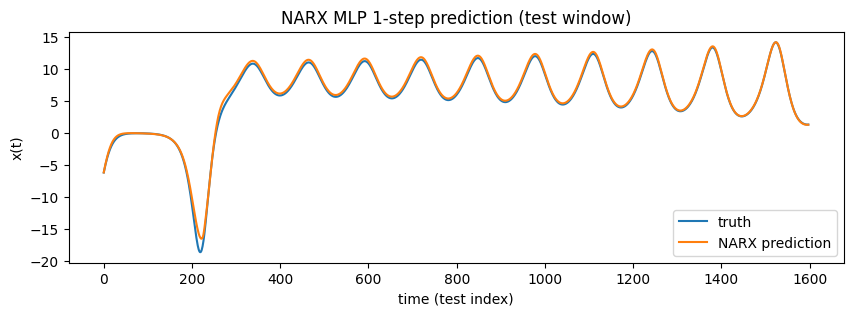

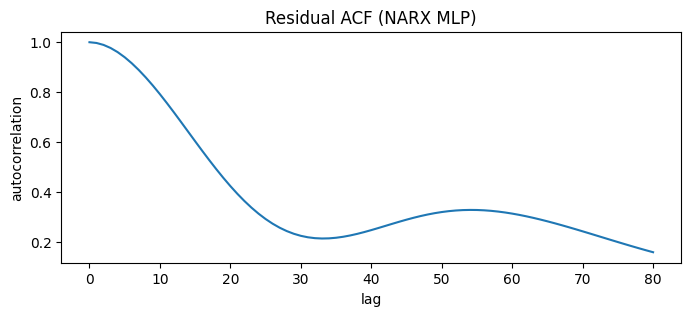

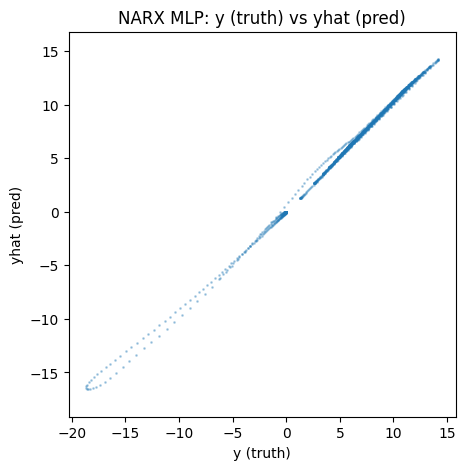

Done.


In [ ]:
# Fast NARX run: fewer steps so it completes quickly.
# Changes: T_steps=8000, epochs=80, hidden=48

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

def lorenz(T_steps=8000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
        k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
        k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

def make_lag_matrix_multi(target, exog_list, p_t=10, p_e=10):
    N = len(target)
    p = max(p_t, p_e)
    n_eff = N - p
    y = target[p:].copy()
    cols = []
    for i in range(1, p_t+1):
        cols.append(target[p - i: N - i])
    for ex in exog_list:
        for i in range(1, p_e+1):
            cols.append(ex[p - i: N - i])
    X = np.column_stack(cols)
    return X, y

def zscore_train_test(X_tr, X_te):
    mu = X_tr.mean(axis=0)
    sd = X_tr.std(axis=0)
    sd[sd == 0] = 1.0
    return (X_tr - mu)/sd, (X_te - mu)/sd

xs, ys, zs = lorenz()
p_t = 10; p_e = 10
X_all, y_all = make_lag_matrix_multi(xs, [ys, zs], p_t=p_t, p_e=p_e)
N = len(y_all)
n_tr = int(0.8 * N)
X_tr, y_tr = X_all[:n_tr], y_all[:n_tr]
X_te, y_te = X_all[n_tr:], y_all[n_tr:]

X_tr_z, X_te_z = zscore_train_test(X_tr, X_te)

# Linear baseline
Xtr_lin = np.column_stack([np.ones(n_tr), X_tr_z])
Xte_lin = np.column_stack([np.ones(len(X_te_z)), X_te_z])
w_lin = np.linalg.lstsq(Xtr_lin, y_tr, rcond=None)[0]
yhat_lin = Xte_lin @ w_lin

def metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    corr = (yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp))
    return mse, mae, corr

mse_lin, mae_lin, r_lin = metrics(y_te, yhat_lin)

# Simple MLP with Adam
class MLP:
    def __init__(self, in_dim, hidden=48, lr=1e-3, l2=1e-4, seed=0):
        self.rng = np.random.default_rng(seed)
        self.W1 = self.rng.normal(0, 1/np.sqrt(in_dim), size=(in_dim, hidden))
        self.b1 = np.zeros(hidden)
        self.W2 = self.rng.normal(0, 1/np.sqrt(hidden), size=(hidden, 1))
        self.b2 = np.zeros(1)
        self.lr = lr; self.l2 = l2
        self.m = [np.zeros_like(self.W1), np.zeros_like(self.b1),
                  np.zeros_like(self.W2), np.zeros_like(self.b2)]
        self.v = [np.zeros_like(self.W1), np.zeros_like(self.b1),
                  np.zeros_like(self.W2), np.zeros_like(self.b2)]
        self.t = 0

    def forward(self, X):
        Hpre = X @ self.W1 + self.b1
        H = np.tanh(Hpre)
        Y = H @ self.W2 + self.b2
        return H, Y

    def loss_and_grads(self, X, y):
        n = X.shape[0]
        y = y.reshape(-1, 1)
        H, Y = self.forward(X)
        err = Y - y
        mse = (err**2).mean()
        reg = 0.5 * self.l2 * (np.sum(self.W1**2) + np.sum(self.W2**2))
        loss = mse + reg
        dY = (2.0/n) * err
        dW2 = H.T @ dY + self.l2 * self.W2
        db2 = dY.sum(axis=0)
        dH = dY @ self.W2.T
        dHpre = dH * (1 - H**2)
        dW1 = X.T @ dHpre + self.l2 * self.W1
        db1 = dHpre.sum(axis=0)
        return loss, (dW1, db1, dW2, db2)

    def adam_step(self, grads, beta1=0.9, beta2=0.999, eps=1e-8):
        self.t += 1
        params = [self.W1, self.b1, self.W2, self.b2]
        for i, (P, g) in enumerate(zip(params, grads)):
            self.m[i] = beta1*self.m[i] + (1-beta1)*g
            self.v[i] = beta2*self.v[i] + (1-beta2)*(g*g)
            mhat = self.m[i] / (1 - beta1**self.t)
            vhat = self.v[i] / (1 - beta2**self.t)
            params[i] -= self.lr * mhat / (np.sqrt(vhat) + eps)

    def fit(self, X, y, epochs=80, batch_size=256, verbose=True):
        n = X.shape[0]
        for ep in range(1, epochs+1):
            idx = rng.permutation(n)
            for start in range(0, n, batch_size):
                sl = idx[start:start+batch_size]
                loss, grads = self.loss_and_grads(X[sl], y[sl])
                self.adam_step(grads)
            if verbose and (ep % 20 == 0 or ep == 1):
                print(f"epoch {ep:03d} - minibatch loss {loss:.6f}")

    def predict(self, X):
        _, Y = self.forward(X)
        return Y.ravel()

mlp = MLP(in_dim=X_tr_z.shape[1], hidden=48, lr=1e-3, l2=1e-4, seed=0)
mlp.fit(X_tr_z, y_tr, epochs=80, batch_size=256, verbose=True)
yhat_narx = mlp.predict(X_te_z)

mse_nx, mae_nx, r_nx = metrics(y_te, yhat_narx)

print("\n=== Test metrics ===")
print(f"Linear ARX -> MSE={mse_lin:.6f}, MAE={mae_lin:.6f}, corr={r_lin:.4f}")
print(f"NARX  (MLP)-> MSE={mse_nx:.6f}, MAE={mae_nx:.6f}, corr={r_nx:.4f}")

# Plots
win = slice(0, min(2000, len(y_te)))
plt.figure(figsize=(10, 3))
plt.plot(y_te[win], label="truth")
plt.plot(yhat_narx[win], label="NARX prediction")
plt.title("NARX MLP 1-step prediction (test window)")
plt.xlabel("time (test index)"); plt.ylabel("x(t)")
plt.legend()
plt.show()

def acf(sig, nlags=80):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac = ac / ac[0]
    return ac[:nlags+1]

resid = y_te - yhat_narx
plt.figure(figsize=(8, 3))
plt.plot(acf(resid, nlags=80))
plt.title("Residual ACF (NARX MLP)")
plt.xlabel("lag"); plt.ylabel("autocorrelation")
plt.show()

plt.figure(figsize=(5,5))
plt.plot(y_te, yhat_narx, '.', alpha=0.3, markersize=2)
plt.title("NARX MLP: y (truth) vs yhat (pred)")
plt.xlabel("y (truth)"); plt.ylabel("yhat (pred)")
plt.axis('equal')
plt.show()

print("Done.")


epoch 001 - minibatch loss 38.181101
epoch 010 - minibatch loss 3.797313
epoch 020 - minibatch loss 0.960081
epoch 030 - minibatch loss 0.474098
epoch 040 - minibatch loss 0.446457

=== Test metrics ===
Linear ARX -> MSE=0.000000, MAE=0.000000, corr=1.0000
NARX  (MLP)-> MSE=0.387376, MAE=0.380736, corr=0.9973


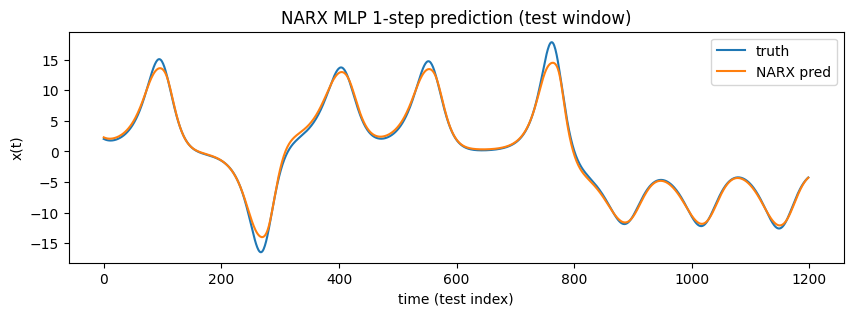

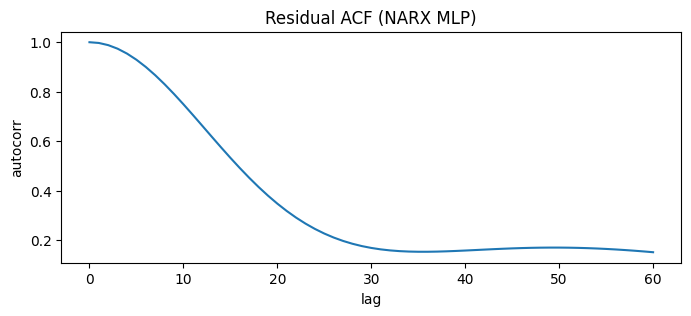

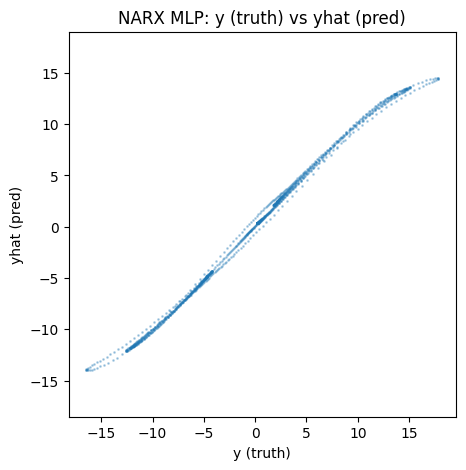

In [ ]:
# -*- coding: utf-8 -*-
"""
NARX for Lorenz x(t) with exogenous y(t), z(t)
- No external ML libs; pure NumPy MLP with Adam
- One-step ahead prediction
- Quick to run; scale up hyperparams for better accuracy
"""

import numpy as np
import matplotlib.pyplot as plt

# ---------------- Lorenz integrator ----------------
def lorenz(T_steps=6000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0,1.0,1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            return (
                sigma*(y-x),
                x*(rho - z) - y,
                x*y - beta*z
            )
        k1 = f(x,y,z)
        k2 = f(x+0.5*dt*k1[0], y+0.5*dt*k1[1], z+0.5*dt*k1[2])
        k3 = f(x+0.5*dt*k2[0], y+0.5*dt*k2[1], z+0.5*dt*k2[2])
        k4 = f(x+dt*k3[0], y+dt*k3[1], z+dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

# --------------- NARX feature builder ---------------
def make_lag_matrix_multi(target, exog_list, p_t=8, p_e=8):
    """
    X rows: [x_{t-1..t-p_t}, y_{t-1..t-p_e}, z_{t-1..t-p_e}]
    y: x_t
    """
    N = len(target)
    p = max(p_t, p_e)
    y = target[p:].copy()
    cols = []
    for i in range(1, p_t+1):
        cols.append(target[p - i : N - i])
    for ex in exog_list:
        for i in range(1, p_e+1):
            cols.append(ex[p - i : N - i])
    X = np.column_stack(cols)
    return X, y

def zscore_train_test(X_tr, X_te):
    mu = X_tr.mean(axis=0)
    sd = X_tr.std(axis=0); sd[sd==0] = 1.0
    return (X_tr-mu)/sd, (X_te-mu)/sd, mu, sd

# ----------------- Tiny NumPy MLP -------------------
class MLP:
    def __init__(self, in_dim, hidden=32, lr=2e-3, l2=1e-4, seed=0):
        rng = np.random.default_rng(seed)
        self.W1 = rng.normal(0, 1/np.sqrt(in_dim), size=(in_dim, hidden))
        self.b1 = np.zeros(hidden)
        self.W2 = rng.normal(0, 1/np.sqrt(hidden), size=(hidden, 1))
        self.b2 = np.zeros(1)
        self.lr = lr; self.l2 = l2
        self.m = [np.zeros_like(self.W1), np.zeros_like(self.b1),
                  np.zeros_like(self.W2), np.zeros_like(self.b2)]
        self.v = [np.zeros_like(self.W1), np.zeros_like(self.b1),
                  np.zeros_like(self.W2), np.zeros_like(self.b2)]
        self.t = 0

    def forward(self, X):
        Hpre = X @ self.W1 + self.b1
        H = np.tanh(Hpre)
        Y = H @ self.W2 + self.b2
        return H, Y

    def loss_and_grads(self, X, y):
        n = X.shape[0]
        y = y.reshape(-1,1)
        H, Y = self.forward(X)
        err = Y - y
        mse = (err**2).mean()
        reg = 0.5*self.l2*(np.sum(self.W1**2)+np.sum(self.W2**2))
        loss = mse + reg
        dY = (2.0/n)*err
        dW2 = H.T @ dY + self.l2*self.W2
        db2 = dY.sum(axis=0)
        dH  = dY @ self.W2.T
        dHpre = dH * (1 - H**2)
        dW1 = X.T @ dHpre + self.l2*self.W1
        db1 = dHpre.sum(axis=0)
        return loss, (dW1, db1, dW2, db2)

    def adam_step(self, grads, beta1=0.9, beta2=0.999, eps=1e-8):
        self.t += 1
        params = [self.W1, self.b1, self.W2, self.b2]
        for i, (P, g) in enumerate(zip(params, grads)):
            self.m[i] = beta1*self.m[i] + (1-beta1)*g
            self.v[i] = beta2*self.v[i] + (1-beta2)*(g*g)
            mhat = self.m[i] / (1 - beta1**self.t)
            vhat = self.v[i] / (1 - beta2**self.t)
            params[i] -= self.lr * mhat / (np.sqrt(vhat) + eps)

    def fit(self, X, y, epochs=40, batch_size=256, verbose=True, seed=1):
        rng = np.random.default_rng(seed)
        n = X.shape[0]
        for ep in range(1, epochs+1):
            idx = rng.permutation(n)
            for s in range(0, n, batch_size):
                sl = idx[s:s+batch_size]
                loss, grads = self.loss_and_grads(X[sl], y[sl])
                self.adam_step(grads)
            if verbose and (ep % 10 == 0 or ep == 1):
                print(f"epoch {ep:03d} - minibatch loss {loss:.6f}")

    def predict(self, X):
        _, Y = self.forward(X)
        return Y.ravel()

# ----------------- Train & evaluate ------------------
# data
xs, ys, zs = lorenz(T_steps=6000)  # raise to 12k/20k for better accuracy
p_t, p_e = 8, 8
X_all, y_all = make_lag_matrix_multi(xs, [ys, zs], p_t=p_t, p_e=p_e)
N   = len(y_all)
ntr = int(0.8*N)
X_tr, y_tr = X_all[:ntr], y_all[:ntr]
X_te, y_te = X_all[ntr:], y_all[ntr:]

# scale features
X_tr_z, X_te_z, muX, sdX = zscore_train_test(X_tr, X_te)

# linear ARX baseline (OLS)
Xtr_lin = np.column_stack([np.ones(ntr), X_tr_z])
Xte_lin = np.column_stack([np.ones(len(X_te_z)), X_te_z])
w_lin   = np.linalg.lstsq(Xtr_lin, y_tr, rcond=None)[0]
yhat_lin = Xte_lin @ w_lin

def metrics(y_true, y_pred):
    mse = np.mean((y_true-y_pred)**2)
    mae = np.mean(np.abs(y_true-y_pred))
    yt  = y_true - y_true.mean()
    yp  = y_pred - y_pred.mean()
    corr = (yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp))
    return mse, mae, corr

mse_lin, mae_lin, r_lin = metrics(y_te, yhat_lin)

# NARX (MLP)
mlp = MLP(in_dim=X_tr_z.shape[1], hidden=32, lr=2e-3, l2=1e-4, seed=0)
mlp.fit(X_tr_z, y_tr, epochs=40, batch_size=256, verbose=True)
yhat_narx = mlp.predict(X_te_z)

mse_nx, mae_nx, r_nx = metrics(y_te, yhat_narx)

print("\n=== Test metrics ===")
print(f"Linear ARX -> MSE={mse_lin:.6f}, MAE={mae_lin:.6f}, corr={r_lin:.4f}")
print(f"NARX  (MLP)-> MSE={mse_nx:.6f}, MAE={mae_nx:.6f}, corr={r_nx:.4f}")

# ----------------- (Optional) quick plots -----------------
SHOW_PLOTS = True
if SHOW_PLOTS:
    win = slice(0, min(1500, len(y_te)))
    plt.figure(figsize=(10,3))
    plt.plot(y_te[win], label="truth")
    plt.plot(yhat_narx[win], label="NARX pred")
    plt.title("NARX MLP 1-step prediction (test window)")
    plt.xlabel("time (test index)"); plt.ylabel("x(t)"); plt.legend()
    plt.show()

    def acf(sig, nlags=60):
        s = sig - sig.mean()
        ac = np.correlate(s, s, mode="full")
        ac = ac[ac.size//2:]
        ac = ac / ac[0]
        return ac[:nlags+1]

    resid = y_te - yhat_narx
    plt.figure(figsize=(8,3))
    plt.plot(acf(resid, nlags=60))
    plt.title("Residual ACF (NARX MLP)")
    plt.xlabel("lag"); plt.ylabel("autocorr")
    plt.show()

    plt.figure(figsize=(5,5))
    plt.plot(y_te, yhat_narx, '.', alpha=0.3, markersize=2)
    plt.title("NARX MLP: y (truth) vs yhat (pred)")
    plt.xlabel("y (truth)"); plt.ylabel("yhat (pred)"); plt.axis("equal")
    plt.show()


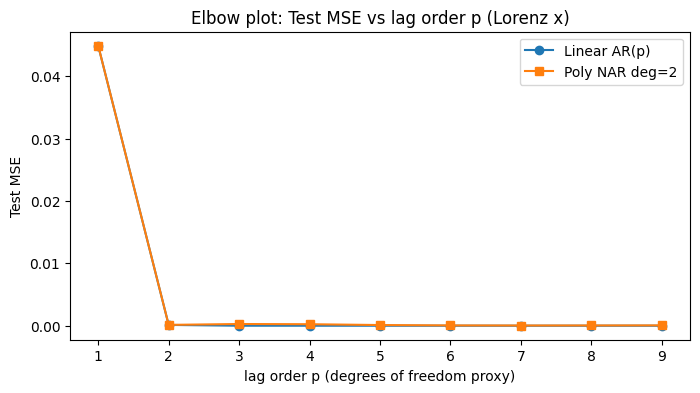

Best p (AR):   p=9, MSE=0.000000
Best p (NAR2): p=7, MSE=0.000034


In [ ]:
# Elbow plot: test MSE vs lag order p for Lorenz x(t)
# Compares linear AR(p) and polynomial NAR(p, degree=2) with ridge.
# One chart (no subplots), matplotlib only, no explicit colors.

import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

# ---------- Lorenz integrator (fast) ----------
def lorenz(T_steps=6000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
        k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
        k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

xs, ys, zs = lorenz()

# ---------- Feature builders ----------
def make_lag_matrix(x, p):
    N = len(x)
    y = x[p:].copy()
    X = np.zeros((N-p, p))
    for i in range(p):
        X[:, i] = x[p-1-i : N-1-i]
    return X, y

def poly_expand_deg2(X):
    # degree 1 and 2 terms (no intercept)
    n, p = X.shape
    cols = [X[:, i] for i in range(p)]
    for i in range(p):
        cols.append(X[:, i] * X[:, i])  # squares
    for i in range(p):
        for j in range(i+1, p):
            cols.append(X[:, i] * X[:, j])  # cross
    return np.column_stack(cols) if cols else np.zeros((n,0))

def standardize_train_test(Z_tr, Z_te):
    mu = Z_tr.mean(axis=0)
    sd = Z_tr.std(axis=0); sd[sd==0]=1.0
    return (Z_tr-mu)/sd, (Z_te-mu)/sd

def fit_ols(D, y):
    return np.linalg.lstsq(D, y, rcond=None)[0]

def fit_ridge(D, y, alpha=1e-2):
    DtD = D.T @ D
    A = DtD + alpha * np.eye(D.shape[1])  # penalize all except we include intercept as column 0 but still mild
    b = D.T @ y
    return np.linalg.solve(A, b)

def mse(y, yhat):
    return np.mean((y-yhat)**2)

# ---------- Sweep p and compute test MSE ----------
p_list = list(range(1, 10))  # 2..20
mse_ar = []
mse_nar2 = []

for p in p_list:
    X, y = make_lag_matrix(xs, p)
    N = len(y)
    n_tr = int(0.8 * N)
    X_tr, y_tr = X[:n_tr], y[:n_tr]
    X_te, y_te = X[n_tr:], y[n_tr:]

    # Linear AR(p)
    D_tr = np.column_stack([np.ones(n_tr), X_tr])
    D_te = np.column_stack([np.ones(len(X_te)), X_te])
    w_ar = fit_ols(D_tr, y_tr)
    mse_ar.append(mse(y_te, D_te @ w_ar))

    # Polynomial NAR degree 2 (ridge)
    Z_tr = poly_expand_deg2(X_tr)
    Z_te = poly_expand_deg2(X_te)
    Z_tr_z, Z_te_z = standardize_train_test(Z_tr, Z_te)
    Dn_tr = np.column_stack([np.ones(n_tr), Z_tr_z])
    Dn_te = np.column_stack([np.ones(len(Z_te_z)), Z_te_z])
    w_nar = fit_ridge(Dn_tr, y_tr, alpha=1e-2)
    mse_nar2.append(mse(y_te, Dn_te @ w_nar))

# ---------- Plot elbow-style curve ----------
plt.figure(figsize=(8, 4))
plt.plot(p_list, mse_ar, marker='o', label='Linear AR(p)')
plt.plot(p_list, mse_nar2, marker='s', label='Poly NAR deg=2')
plt.title("Elbow plot: Test MSE vs lag order p (Lorenz x)")
plt.xlabel("lag order p (degrees of freedom proxy)")
plt.ylabel("Test MSE")
plt.legend()
plt.show()

# Print minimal MSE choices
best_ar_p = p_list[int(np.argmin(mse_ar))]
best_nar_p = p_list[int(np.argmin(mse_nar2))]
print(f"Best p (AR):   p={best_ar_p}, MSE={min(mse_ar):.6f}")
print(f"Best p (NAR2): p={best_nar_p}, MSE={min(mse_nar2):.6f}")


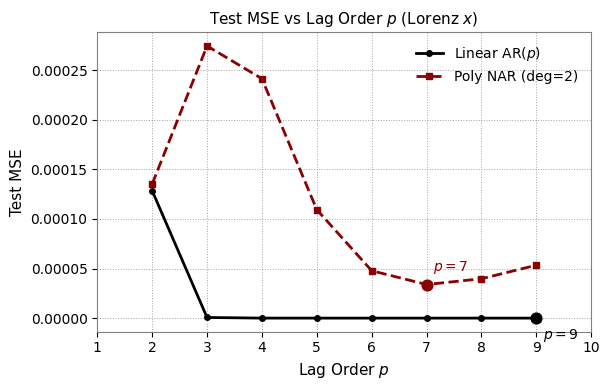

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.2, 4))

# Plot AR(p) in black
plt.plot(p_list, (mse_ar), '-o', color='black', linewidth=2, markersize=4, label='Linear AR($p$)')

# Plot NAR deg=2 in dark red
plt.plot(p_list, (mse_nar2), '--s', color='darkred', linewidth=2, markersize=4, label='Poly NAR (deg=2)')

# Highlight minima
plt.scatter(best_ar_p, min(mse_ar), color='black', s=60, zorder=3)
plt.scatter(best_nar_p, min(mse_nar2), color='darkred', s=60, zorder=3)

# Annotate minima
plt.annotate(f"$p={best_ar_p}$", 
             (best_ar_p, min(mse_ar)), 
             xytext=(5, -15), textcoords="offset points",
             fontsize=10, color='black')

plt.annotate(f"$p={best_nar_p}$", 
             (best_nar_p, min(mse_nar2)), 
             xytext=(5, 10), textcoords="offset points",
             fontsize=10, color='darkred')

# Labels and title
plt.title("Test MSE vs Lag Order $p$ (Lorenz $x$)", fontsize=11)
plt.xlabel("Lag Order $p$", fontsize=11)
plt.ylabel("Test MSE", fontsize=11)

# Legend (no box, subtle)
plt.legend(frameon=False, fontsize=10)

# X-axis limit
plt.xlim(1, 10)
plt.xticks(range(1, 11))

# Aesthetic tweaks: light gray grid and spines
plt.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7, color='gray')
for spine in plt.gca().spines.values():
    spine.set_color('gray')

plt.tick_params(axis='both', labelsize=10, colors='black')

plt.tight_layout()
plt.show()


Time varying AR

Best p by TEST MSE: p=19, MSE=0.000000
Best p by BIC (training fit): p=8


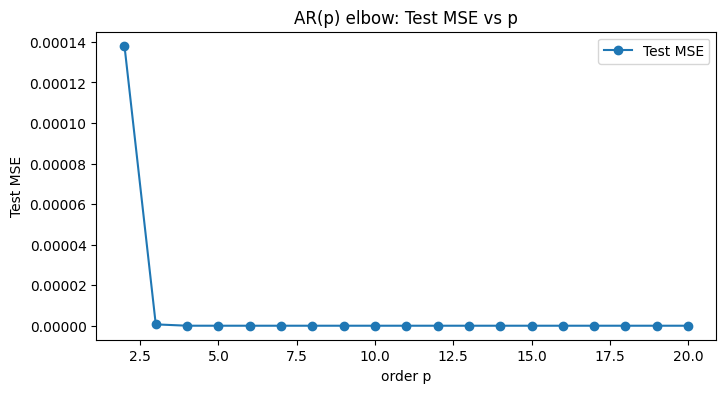

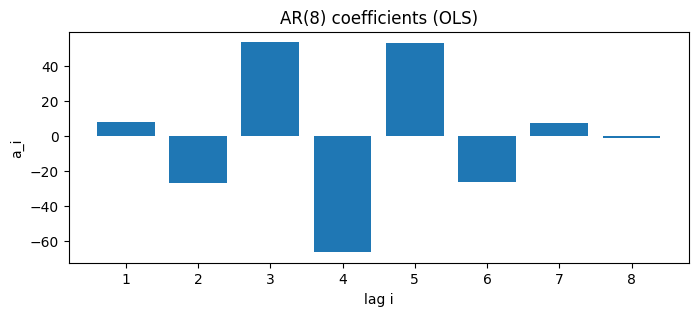

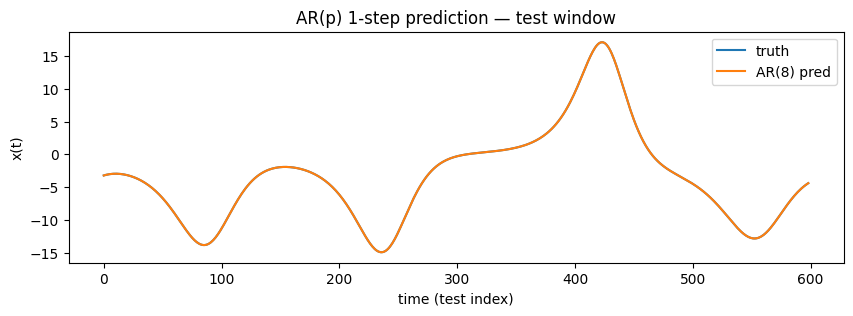

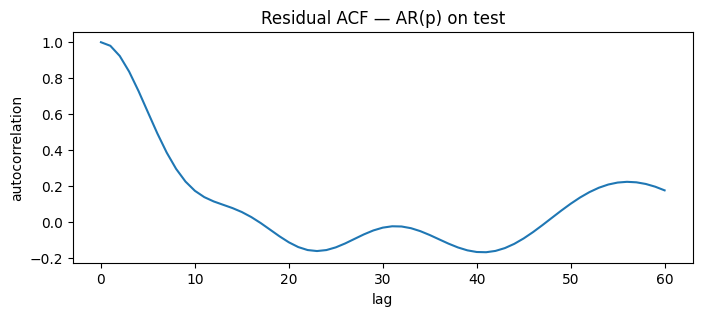

AR(8) metrics — train: MSE=0.000000, MAE=0.000000, corr=1.0000
AR(8) metrics — test:  MSE=0.000000, MAE=0.000000, corr=1.0000


In [7]:
# Running your AR(p) baseline exactly as provided to produce the plots & metrics.
import numpy as np
import matplotlib.pyplot as plt

# ---------- Data (Lorenz) ----------
def lorenz(T_steps=3000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0,1.0,1.0)):
    x, y, z = x0
    xs, ys, zs = [], [], []
    for _ in range(T_steps):
        def f(x,y,z):
            dx = sigma*(y-x)
            dy = x*(rho - z) - y
            dz = x*y - beta*z
            return dx, dy, dz
        k1 = f(x,y,z)
        k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
        k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
        k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
        x += (dt/6.0)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

xs, ys, zs = lorenz()

# ---------- AR helpers ----------
def lag_matrix(x, p):
    N = len(x)
    y = x[p:].copy()
    X = np.zeros((N-p, p))
    for i in range(p):
        X[:, i] = x[p-1-i : N-1-i]
    return X, y

def ols_with_intercept(X, y):
    D = np.column_stack([np.ones(len(X)), X])
    w = np.linalg.lstsq(D, y, rcond=None)[0]
    return w  # [c, a1..ap]

def predict_from_params(X, w):
    D = np.column_stack([np.ones(len(X)), X])
    return D @ w

def metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    r = (yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp))
    return mse, mae, r

def acf(sig, nlags=60):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac = ac / (ac[0] if ac[0] != 0 else 1.0)
    return ac[:nlags+1]

def aic_bic(y, yhat, k):
    # k = number of estimated params incl. intercept
    n = len(y)
    rss = np.sum((y - yhat)**2)
    sigma2 = rss / n
    aic = n*np.log(sigma2 + 1e-12) + 2*k
    bic = n*np.log(sigma2 + 1e-12) + k*np.log(n)
    return aic, bic

# ---------- Sweep p and pick best ----------
p_list = list(range(2, 21))
mse_te_list, aic_list, bic_list = [], [], []
params_by_p = {}
splits = {}

for p in p_list:
    X, y = lag_matrix(xs, p)
    N = len(y)
    ntr = int(0.8 * N)
    X_tr, y_tr = X[:ntr], y[:ntr]
    X_te, y_te = X[ntr:], y[ntr:]
    w = ols_with_intercept(X_tr, y_tr)
    yhat_tr = predict_from_params(X_tr, w)
    yhat_te = predict_from_params(X_te, w)
    mse_te, _, _ = metrics(y_te, yhat_te)
    aic, bic = aic_bic(y_tr, yhat_tr, k=p+1)
    mse_te_list.append(mse_te); aic_list.append(aic); bic_list.append(bic)
    params_by_p[p] = w
    splits[p] = (ntr, y, yhat_tr, yhat_te)

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]
best_p_by_bic = p_list[int(np.argmin(bic_list))]

print(f"Best p by TEST MSE: p={best_p_by_mse}, MSE={min(mse_te_list):.6f}")
print(f"Best p by BIC (training fit): p={best_p_by_bic}")

# ---------- Plot elbow (MSE vs p) ----------
plt.figure(figsize=(8,4))
plt.plot(p_list, mse_te_list, marker='o', label='Test MSE')
plt.title("AR(p) elbow: Test MSE vs p")
plt.xlabel("order p"); plt.ylabel("Test MSE"); plt.legend()
plt.show()

# ---------- Coefficients for chosen p ----------
# p_use = best_p_by_bic  # or best_p_by_mse
# w = params_by_p[p_use]
# plt.figure(figsize=(8,3))
# plt.stem(np.arange(1, p_use+1), w[1:], use_line_collection=True)
# plt.title(f"AR({p_use}) coefficients (OLS)")
# plt.xlabel("lag i"); plt.ylabel("a_i")
# plt.show()

p_use = best_p_by_bic
w = params_by_p[p_use]
plt.figure(figsize=(8,3))
plt.bar(np.arange(1, p_use+1), w[1:])
plt.title(f"AR({p_use}) coefficients (OLS)")
plt.xlabel("lag i"); plt.ylabel("a_i")
plt.show()

# ---------- Test-window prediction ----------
ntr, y_all, yhat_tr, yhat_te = splits[p_use]
X, y = lag_matrix(xs, p_use)
plt.figure(figsize=(10,3))
win = slice(ntr, min(ntr+1500, len(y)))
plt.plot(y[win], label="truth")
plt.plot(yhat_te[:win.stop-win.start], label=f"AR({p_use}) pred")
plt.title("AR(p) 1-step prediction — test window")
plt.xlabel("time (test index)"); plt.ylabel("x(t)"); plt.legend()
plt.show()

# ---------- Residual ACF (test) ----------
resid_te = y[ntr:] - yhat_te
plt.figure(figsize=(8,3))
plt.plot(acf(resid_te, nlags=60))
plt.title("Residual ACF — AR(p) on test")
plt.xlabel("lag"); plt.ylabel("autocorrelation")
plt.show()

mse_tr, mae_tr, r_tr = metrics(y[:ntr], yhat_tr)
mse_te, mae_te, r_te = metrics(y[ntr:], yhat_te)
print(f"AR({p_use}) metrics — train: MSE={mse_tr:.6f}, MAE={mae_tr:.6f}, corr={r_tr:.4f}")
print(f"AR({p_use}) metrics — test:  MSE={mse_te:.6f}, MAE={mae_te:.6f}, corr={r_te:.4f}")


In [9]:
# ---------- Data (synthetic LFP-like) ----------
import numpy as np

def make_lfp_like(fs=500, duration_s=120, alpha=1.0, seed=0,
                  bands=((6.0, 0.9, 10), (20.0, 0.6, 8), (45.0, 0.4, 8)),
                  add_line_60hz=True, line_amp=0.08,
                  ou_tau_s=8.0, ou_sigma=0.15):
    """
    Lightweight LFP-like signal:
      - 1/f^alpha colored noise background
      - slow OU drift
      - Gaussian-burst amplitude-modulated narrowband oscillations (theta/beta/gamma)
      - optional 60 Hz line noise
    Returns:
      xs (float64) z-scored LFP-like signal, length = fs*duration_s
      fs (int) sampling rate
    """
    rng = np.random.default_rng(seed)
    N = int(fs * duration_s)
    t = np.arange(N) / fs

    # ---- 1/f^alpha colored noise via frequency-domain shaping ----
    freqs = np.fft.rfftfreq(N, d=1/fs)
    amp = np.ones_like(freqs)
    # avoid div-by-zero at DC; set DC small
    f0 = 1.0 / duration_s
    amp[1:] = (freqs[1:] / f0) ** (-alpha/2.0)
    # white complex spectrum with random phase
    re = rng.normal(size=len(freqs))
    im = rng.normal(size=len(freqs))
    S = (re + 1j*im) * amp
    S[0] = 0.0  # no DC blow-up
    x_colored = np.fft.irfft(S, n=N).real
    x_colored /= (np.std(x_colored) + 1e-12)

    # ---- Slow OU drift ----
    dt = 1.0 / fs
    a = np.exp(-dt / ou_tau_s)
    x_ou = np.zeros(N, dtype=np.float64)
    noise_scale = ou_sigma * np.sqrt(1 - a*a)
    for n in range(1, N):
        x_ou[n] = a * x_ou[n-1] + noise_scale * rng.normal()

    # ---- Band bursts: Gaussian-enveloped sinusoids ----
    def burst_envelope(n_bursts, t, rng, width_range=(0.15, 0.6)):
        env = np.zeros_like(t)
        T = t[-1]
        for _ in range(n_bursts):
            c = rng.uniform(0.5, T-0.5)          # center time (avoid edges)
            sigma = rng.uniform(*width_range)     # seconds
            env += np.exp(-0.5 * ((t - c)/sigma)**2)
        return env

    x_bands = np.zeros_like(t)
    for f, base_amp, n_bursts in bands:
        phase = rng.uniform(0, 2*np.pi)
        env = burst_envelope(n_bursts, t, rng)
        env = env / (env.max() + 1e-12)          # normalize envelope
        x_bands += base_amp * env * np.sin(2*np.pi*f*t + phase)

    # ---- 60 Hz line noise (optional) ----
    x_line = np.zeros_like(t)
    if add_line_60hz:
        x_line = line_amp * np.sin(2*np.pi*60.0*t + rng.uniform(0, 2*np.pi))

    # ---- Mix and z-score ----
    x = 0.55*x_colored + 0.25*x_ou + 0.20*x_bands + x_line
    xs = (x - np.mean(x)) / (np.std(x) + 1e-12)
    return xs.astype(np.float64), fs

# Use this instead of `xs, ys, zs = lorenz()`
xs, fs = make_lfp_like(fs=500, duration_s=120, alpha=1.0, seed=7)


Best p by TEST MSE: p=16, MSE=0.303008
Best p by BIC (training fit): p=16


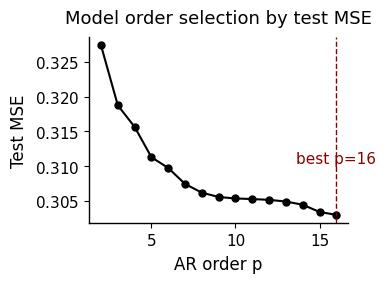

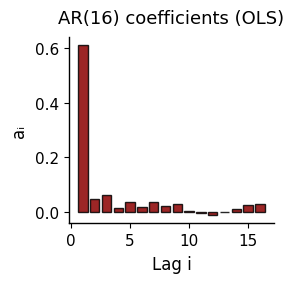

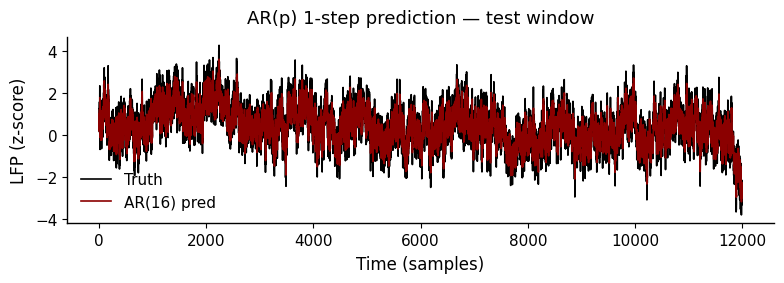

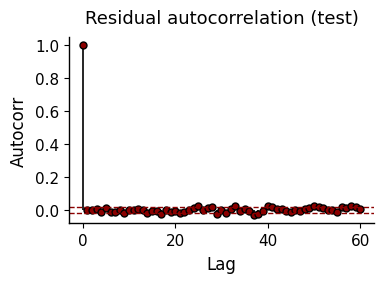

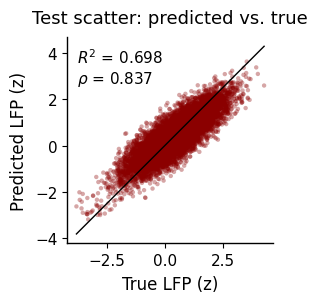

AR(16) metrics — train: MSE=0.301282, MAE=0.438073, corr=0.8236
AR(16) metrics — test:  MSE=0.303008, MAE=0.438900, corr=0.8368


In [10]:
# =======================
# AR helpers, sweep, and plots (black/darkred)
# =======================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ----- Style -----
plt.rcParams.update({
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 13,
    "legend.fontsize": 11, "xtick.labelsize": 11, "ytick.labelsize": 11,
    "axes.spines.top": False, "axes.spines.right": False
})
color_main = "black"
color_alt  = "darkred"

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    if title:  ax.set_title(title, pad=10)
    if xlabel: ax.set_xlabel(xlabel, labelpad=5)
    if ylabel: ax.set_ylabel(ylabel, labelpad=5)
    if add_legend: ax.legend(frameon=False)
    for s in ("left","bottom"):
        ax.spines[s].set_linewidth(1.0)

# ----- Core helpers -----
def lag_matrix(x, p):
    N = len(x)
    y = x[p:].copy()
    X = np.zeros((N-p, p))
    for i in range(p):
        X[:, i] = x[p-1-i : N-1-i]
    return X, y

def ols_with_intercept(X, y):
    D = np.column_stack([np.ones(len(X)), X])
    return np.linalg.lstsq(D, y, rcond=None)[0]  # [c, a1..ap]

def predict_from_params(X, w):
    D = np.column_stack([np.ones(len(X)), X])
    return D @ w

def metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    yt  = y_true - np.mean(y_true)
    yp  = y_pred - np.mean(y_pred)
    r   = (yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12)
    return mse, mae, r

def acf_simple(sig, nlags=60):
    s  = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac = ac / (ac[0] if ac[0] != 0 else 1.0)
    return ac[:nlags+1]

# =======================
# 1) AR(p) sweep on xs
# =======================
p_list = list(range(2, 17))  # try 2..16
mse_te_list, aic_list, bic_list = [], [], []
params_by_p, splits = {}, {}

for p in p_list:
    X, y = lag_matrix(xs, p)
    N = len(y)
    ntr = int(0.8 * N)
    X_tr, y_tr = X[:ntr], y[:ntr]
    X_te, y_te = X[ntr:], y[ntr:]

    w = ols_with_intercept(X_tr, y_tr)
    yhat_tr = predict_from_params(X_tr, w)
    yhat_te = predict_from_params(X_te, w)

    # metrics on test
    mse_te, _, _ = metrics(y_te, yhat_te)

    # AIC/BIC on training (k = p + intercept)
    rss    = np.sum((y_tr - yhat_tr)**2)
    sigma2 = rss / max(len(y_tr), 1)
    k      = p + 1
    aic    = len(y_tr)*np.log(sigma2 + 1e-12) + 2*k
    bic    = len(y_tr)*np.log(sigma2 + 1e-12) + k*np.log(max(len(y_tr), 2))

    mse_te_list.append(mse_te); aic_list.append(aic); bic_list.append(bic)
    params_by_p[p] = w
    splits[p] = (ntr, y, yhat_tr, yhat_te)

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]
best_p_by_bic = p_list[int(np.argmin(bic_list))]
print(f"Best p by TEST MSE: p={best_p_by_mse}, MSE={min(mse_te_list):.6f}")
print(f"Best p by BIC (training fit): p={best_p_by_bic}")

# =======================
# 2) Plots (a–e)
# =======================

# (a) Elbow: Test MSE vs p
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(p_list, mse_te_list, marker='o', color=color_main, lw=1.5, ms=5)
ax.axvline(best_p_by_mse, linestyle='--', color=color_alt, linewidth=1)
ax.text(best_p_by_mse, ax.get_ylim()[1]*0.95, f"best p={best_p_by_mse}",
        ha='center', va='top', color=color_alt, fontsize=11)
sf = ScalarFormatter(useMathText=True); sf.set_powerlimits((-3, 3))
ax.yaxis.set_major_formatter(sf)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
ax.yaxis.get_offset_text().set_size(10)
prettify(ax, title="Model order selection by test MSE", xlabel="AR order p", ylabel="Test MSE")
plt.tight_layout(); plt.show()

# (b) Coefficients at BIC-selected order
p_use = best_p_by_bic
w = params_by_p[p_use]
fig, ax = plt.subplots(figsize=(3,3))
ax.bar(np.arange(1, p_use+1), w[1:], color=color_alt, edgecolor=color_main, alpha=0.85)
prettify(ax, title=f"AR({p_use}) coefficients (OLS)", xlabel="Lag i", ylabel="aᵢ")
plt.tight_layout(); plt.show()

# (c) Test-window prediction (full test set)
ntr, y_all, yhat_tr, yhat_te = splits[p_use]
X, y = lag_matrix(xs, p_use)
fig, ax = plt.subplots(figsize=(8,3))
win = slice(ntr, len(y))
ax.plot(y[win], color=color_main, lw=1.2, label="Truth")
ax.plot(yhat_te[:win.stop-win.start], color=color_alt, lw=1.2, label=f"AR({p_use}) pred")
prettify(ax, title="AR(p) 1-step prediction — test window", xlabel="Time (samples)", ylabel="LFP (z-score)", add_legend=True)
plt.tight_layout(); plt.show()

# (d) Residual ACF with ±1.96/sqrt(N) bounds
resid_te = y[ntr:] - yhat_te
acf_vals = acf_simple(resid_te, nlags=60)
N_te = len(resid_te); bound = 1.96 / np.sqrt(max(N_te, 1))
fig, ax = plt.subplots(figsize=(4,3))
markerline, stemlines, baseline = ax.stem(range(len(acf_vals)), acf_vals, basefmt=" ")
plt.setp(stemlines, color=color_main, linewidth=1.2)
plt.setp(markerline, marker='o', markersize=5, markeredgecolor=color_main, markerfacecolor=color_alt)
ax.axhline(bound,  linestyle='--', color=color_alt, linewidth=1)
ax.axhline(-bound, linestyle='--', color=color_alt, linewidth=1)
prettify(ax, title="Residual autocorrelation (test)", xlabel="Lag", ylabel="Autocorr")
plt.tight_layout(); plt.show()

# (e) Predicted vs True scatter (+ R^2, ρ)
y_true = y[ntr:]; y_pred = yhat_te
fig, ax = plt.subplots(figsize=(3.2,3.2))
ax.scatter(y_true, y_pred, c=color_alt, alpha=0.35, s=10, edgecolors="none")
vmin = min(np.min(y_true), np.min(y_pred)); vmax = max(np.max(y_true), np.max(y_pred))
ax.plot([vmin, vmax], [vmin, vmax], color=color_main, lw=1)
yt = y_true - np.mean(y_true); yp = y_pred - np.mean(y_pred)
corr = float((yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12))
ss_res = np.sum((y_true - y_pred)**2); ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2 = 1 - ss_res / (ss_tot + 1e-12)
ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
        transform=ax.transAxes, ha='left', va='top', fontsize=11,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))
ax.set_aspect('equal', adjustable='box')
prettify(ax, title="Test scatter: predicted vs. true", xlabel="True LFP (z)", ylabel="Predicted LFP (z)")
plt.tight_layout(); plt.show()

# ----- Final metrics (for p_use) -----
mse_tr, mae_tr, r_tr = metrics(y[:ntr], yhat_tr)
mse_te, mae_te, r_te = metrics(y[ntr:], yhat_te)
print(f"AR({p_use}) metrics — train: MSE={mse_tr:.6f}, MAE={mae_tr:.6f}, corr={r_tr:.4f}")
print(f"AR({p_use}) metrics — test:  MSE={mse_te:.6f}, MAE={mae_te:.6f}, corr={r_te:.4f}")


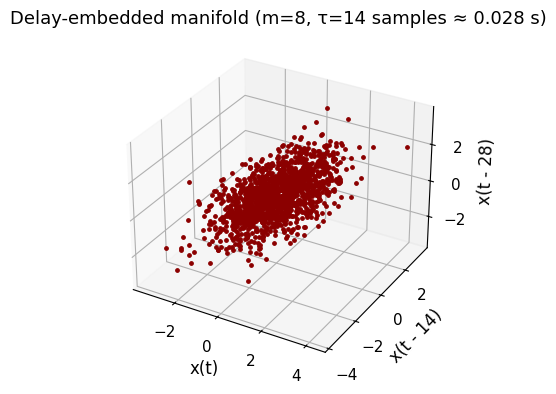

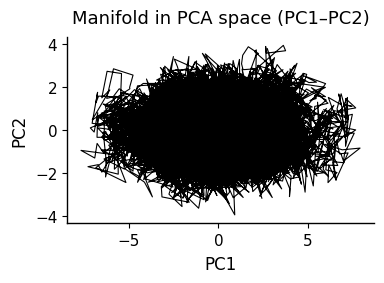

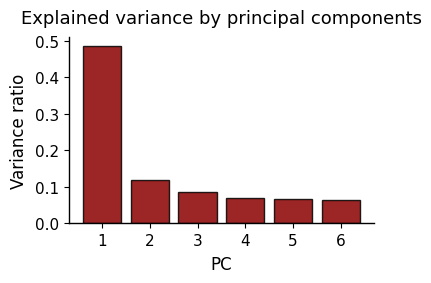

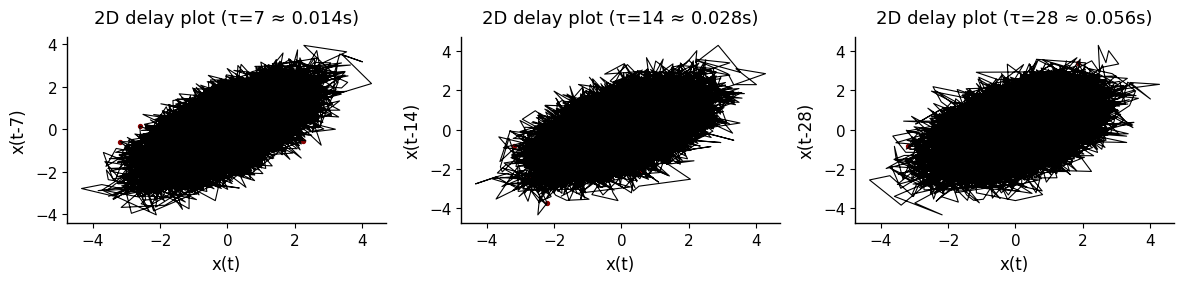

Chosen delay τ = 14 samples (~0.028 s)
Embedding dimension m = 8 (based on AR order)
Top 3 PCA variance ratios: [0.486 0.118 0.087]


In [21]:
# =======================
# Manifold (delay embedding) from the same LFP-like signal xs
# =======================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D proj)
from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator

# ---- fallbacks if not defined above ----
if "color_main" not in globals(): color_main = "black"
if "color_alt"  not in globals(): color_alt  = "darkred"

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    if title:  ax.set_title(title, pad=10)
    if xlabel: ax.set_xlabel(xlabel, labelpad=5)
    if ylabel: ax.set_ylabel(ylabel, labelpad=5)
    if add_legend: ax.legend(frameon=False)
    for s in ("left","bottom"):
        if s in ax.spines: ax.spines[s].set_linewidth(1.0)

def acf_simple(sig, nlags=400):
    s = sig - np.mean(sig)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size//2:]
    ac = ac / (ac[0] if ac[0] != 0 else 1.0)
    return ac[:nlags+1]

def pick_tau_by_acf(x):
    a = acf_simple(x, nlags=400)
    # first local minimum after lag=1
    dif1 = a[1:-1] - a[:-2]
    dif2 = a[2:]   - a[1:-1]
    mins = np.where((dif1 < 0) & (dif2 > 0))[0]  # indices for a[1:-1]
    if len(mins) > 0:
        tau = int(mins[0] + 1)  # shift back to acf index
    else:
        # fallback: first lag where acf < 1/e, else tau=1
        below = np.where(a < np.exp(-1))[0]
        tau = int(below[0]) if len(below) else 1
    tau = max(1, tau)
    return tau, a

def delay_embed(x, m, tau):
    N = len(x)
    L = N - (m-1)*tau
    if L <= 0:
        raise ValueError("Embedding too large for signal length; reduce m or tau.")
    X = np.stack([x[i : i+L : 1] for i in range(0, m*tau, tau)], axis=1)
    return X  # shape (L, m), columns = [x(t), x(t-τ), x(t-2τ), ...]

# -----------------------
# 1) Pick τ and m
# -----------------------
tau, ac = pick_tau_by_acf(xs)
# Use AR order you selected (BIC) + 1 as embedding dim, min 3 for 3D viz, cap to 8
m_embed =  max(3, min(8, (best_p_by_bic if "best_p_by_bic" in globals() else 3) + 1))
# m_embed = 3
# -----------------------
# 2) Build embedding + standardize dims for fair geometry
# -----------------------
Xemb = delay_embed(xs, m_embed, tau)
Xemb = (Xemb - Xemb.mean(0)) / (Xemb.std(0) + 1e-12)

# Small stride for plotting speed if very long
stride = max(1, len(Xemb)//20000)
Xp = Xemb[::stride]

# -----------------------
# 3) 3D trajectory: [x(t), x(t-τ), x(t-2τ)]
# -----------------------
fig = plt.figure(figsize=(5,4))
ax3 = fig.add_subplot(111, projection='3d')
# draw a thin path plus sparse markers
# ax3.plot(Xp[:1000,0], Xp[:1000,1], Xp[:1000,2], lw=0.8, color=color_main, label="Trajectory")
ax3.scatter(Xp[::20,0], Xp[::20,1], Xp[::20,2], s=6, c=color_alt, depthshade=False)
ax3.set_title(f"Delay-embedded manifold (m={m_embed}, τ={tau} samples ≈ {tau/float(fs):.3f} s)")
ax3.set_xlabel("x(t)")
ax3.set_ylabel(f"x(t - {tau})")
ax3.set_zlabel(f"x(t - {2*tau})")
plt.tight_layout(); plt.show()

# -----------------------
# 4) PCA views of the manifold
# -----------------------
pca = PCA(n_components=min(6, m_embed), svd_solver="full")
Z = pca.fit_transform(Xemb)

# (a) 2D PC1–PC2 scatter with thin trajectory line
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(Z[:,0][::stride], Z[:,1][::stride], lw=0.8, color=color_main)
ax.scatter(Z[::2000*stride,0], Z[::2000*stride,1], s=8, c=color_alt)
prettify(ax, title="Manifold in PCA space (PC1–PC2)", xlabel="PC1", ylabel="PC2")
plt.tight_layout(); plt.show()

# (b) Scree (explained variance)
ev = pca.explained_variance_ratio_
fig, ax = plt.subplots(figsize=(4,3))
ax.bar(np.arange(1, len(ev)+1), ev, edgecolor=color_main, color=color_alt, alpha=0.85)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
prettify(ax, title="Explained variance by principal components", xlabel="PC", ylabel="Variance ratio")
plt.tight_layout(); plt.show()

# -----------------------
# 5) (Optional) Compare different τ visually (quick panel)
# -----------------------
taus_to_show = [max(1, tau//2), tau, tau*2][:3]
fig, axes = plt.subplots(1, len(taus_to_show), figsize=(4*len(taus_to_show), 3), squeeze=False)
for j, tauj in enumerate(taus_to_show):
    Xe = delay_embed(xs, 3, tauj)
    Xe = (Xe - Xe.mean(0)) / (Xe.std(0) + 1e-12)
    Xs = Xe[::stride]
    ax = axes[0, j]
    ax.plot(Xs[:,0], Xs[:,1], lw=0.8, color=color_main)
    ax.scatter(Xs[::200,0], Xs[::200,1], s=8, c=color_alt)
    prettify(ax, title=f"2D delay plot (τ={tauj} ≈ {tauj/float(fs):.3f}s)", xlabel="x(t)", ylabel=f"x(t-{tauj})")
plt.tight_layout(); plt.show()

# -----------------------
# 6) (Optional) Report chosen embedding
# -----------------------
print(f"Chosen delay τ = {tau} samples (~{tau/float(fs):.3f} s)")
print(f"Embedding dimension m = {m_embed} (based on AR order)")
print("Top 3 PCA variance ratios:", np.round(ev[:3], 3))
